# Initialize Notebook

## 📖 Citation

This notebook is a replication of the [PCDM demo](https://github.com/tencent-ailab/PCDMs/blob/main/pcdms_demo.ipynb) and is based on the following paper:

> Shen, F., Ye, H., Zhang, J., Wang, C., Han, X., & Wei, Y.  
> *Advancing Pose-Guided Image Synthesis with Progressive Conditional Diffusion Models*.  
> The Twelfth International Conference on Learning Representations (ICLR).

```bibtex
@inproceedings{shenadvancing,
  title={Advancing Pose-Guided Image Synthesis with Progressive Conditional Diffusion Models},
  author={Shen, Fei and Ye, Hu and Zhang, Jun and Wang, Cong and Han, Xiao and Wei, Yang},
  booktitle={The Twelfth International Conference on Learning Representations}
}


In [5]:
# import basics
from pathlib import Path
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
# basics pytorch
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms
# import image encoder
from transformers import CLIPImageProcessor, Dinov2Model
# import diffusion models
from diffusers import (
    AutoencoderKL,           # Autoencoder model
    DDIMScheduler,           # Scheduler for diffusion steps
    UNet2DConditionModel     # Conditional U-Net model
)
from controlnet_aux import OpenposeDetector
from diffusers.models.controlnets.controlnet import ControlNetConditioningEmbedding

# constants uses through whole codebase
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = torch.Generator(device=device).manual_seed(42)

## Clone Repo

In [20]:
import os
import sys
import json
from pathlib import Path
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../../external/PCDMs/src'))

from constants import MODELS_SAVE_PATH, BASE_DIR

small fix in 'external/PCDMs/src/models/stage2_inpaint_unet_2d_condition.py'

in line 35 replace `diffusers.models.unet_2d_blocks` with `diffusers.models.unets.unet_2d_blocks`

In [ ]:
# fix some importing
# replace 'diffusers.models.unets.unet_2d_blocks' with 'diffusers.models.unet_2d_blocks' in 'stage2_inpaint_unet_2d_condition.py'
# !sed -i 's/diffusers\.models\.unet_2d_blocks/diffusers.models.unets.unet_2d_blocks/g' ./src/models/stage2_inpaint_unet_2d_condition.py

## DWpose

I will use `easy-dwpose` instead of `mmpose` which more lightweight because they use onnx

**DON'T** move download cell upward will cause error

In [3]:
# !pip install easy-dwpose > /dev/null

In [6]:
# replace single_extract_pose.py
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet").to(device)

def inference_pose(img_path, image_size=(1024, 1024)):
    img = Image.open(img_path)
    pose = openpose(img, detect_resolution=img.size[1]).resize(img.size, Image.BICUBIC)
    return pose


/home/aliaagheis/miniconda3/envs/fast_env/lib/python3.12/site-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.t

## Download Checkpoint

In [7]:
# ! gdown "1JFFy_FBxOFuGFBcB6xMIVwcQb8bfnpO9" -O "pcdms_ckpt.pt"

# Load Checkpoint

In [9]:
def load_model(ckpt_path = MODELS_SAVE_PATH / "pcdm/pcdms_ckpt.pt"):
    model_ckpt = torch.load(ckpt_path)
    
    unet_dict = {}
    pose_proj_dict = {}
    image_proj_model_dict = {}

    for key, value in model_ckpt['module'].items():
        # sub models
        model_name = key.split('.')[0]
        model_key = key[len(model_name)+1:]
        # put weights in correct dict
        if model_name == 'pose_proj':
            pose_proj_dict[model_key] = value
        elif model_name == 'unet':
            unet_dict[model_key] = value
        elif model_name == 'image_proj_model':
            image_proj_model_dict[model_key] = value
        else:
            raise FileNotFoundError("no model called that")
        
    return unet_dict,  pose_proj_dict,  image_proj_model_dict


unet_dict,  pose_proj_dict,  image_proj_model_dict = load_model()

/tmp/ipykernel_64784/2080854210.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_ckpt = torch.load(ckpt_path)


## Load Components

In [11]:
# loading sd components

from models.stage2_inpaint_unet_2d_condition import Stage2_InapintUNet2DConditionModel

# load unet from "stable diffusion v2.1" and fed it to stag2model
unet = Stage2_InapintUNet2DConditionModel.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16,subfolder="unet",in_channels=9, low_cpu_mem_usage=False, ignore_mismatched_sizes=True).to(device)

# load vae I didn't see it in use in this notebook
# vae = AutoencoderKL.from_pretrained("stabilityai/stable-diffusion-2-1-base",subfolder="vae").to(device, dtype=torch.float16)
noise_scheduler = DDIMScheduler(
    num_train_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.012,
    beta_schedule="scaled_linear",
    clip_sample=False,
    set_alpha_to_one=False,
    steps_offset=1,
)

Some weights of Stage2_InapintUNet2DConditionModel were not initialized from the model checkpoint at stabilityai/stable-diffusion-2-1-base and are newly initialized because the shapes did not match:
- conv_in.weight: found shape torch.Size([320, 4, 3, 3]) in the checkpoint and torch.Size([320, 9, 3, 3]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
# image encoder
image_encoder = Dinov2Model.from_pretrained("facebook/dinov2-giant").to(device, dtype=torch.float16)


# ImageProjModel will project `embeddings` output from `image_encoder` to input to SD
class ImageProjModel(torch.nn.Module):
    """SD model with image prompt"""
    def __init__(self, in_dim, hidden_dim, out_dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.LayerNorm(hidden_dim),
            nn.Linear(hidden_dim, out_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):  
        return self.net(x)
image_proj_model = ImageProjModel(in_dim=1536, hidden_dim=768, out_dim=1024).to(device).to(dtype=torch.float16)

# pose encoder
pose_proj_model = ControlNetConditioningEmbedding(
    conditioning_embedding_channels=320,
    block_out_channels=(16, 32, 96, 256),
    conditioning_channels=3).to(device).to(dtype=torch.float16)

In [15]:
from pipelines.PCDMs_pipeline import PCDMsPipeline

# pipeline of stage2
pipe = PCDMsPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", unet=unet,  torch_dtype=torch.float16, scheduler=noise_scheduler,feature_extractor=None,safety_checker=None).to(device)

Expected types for unet: ['UNet2DConditionModel'], got Stage2_InapintUNet2DConditionModel.


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

## Load checkpoint weights

In [16]:
unet.load_state_dict(unet_dict)
pose_proj_model.load_state_dict(pose_proj_dict)
image_proj_model.load_state_dict(image_proj_model_dict)

<All keys matched successfully>

# Inference Step By Step

In [ ]:
# transformer of data
clip_image_processor = CLIPImageProcessor()
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]), # transform pixels in range [-1, 1]
])

will load image sample 1 step by step

In [21]:
# define some parameters
num_samples = 1
image_size = (512, 512)
s_img_path = BASE_DIR / 'external/PCDMs/imgs/img1.png'
target_pose_img =BASE_DIR / 'external/PCDMs/imgs/pose1.png'

## Preparing Inputs
- In painting input (image || black) + mask of (white || black)
- Pose Condition (src pose || target pose)
- 

### In-painting input

s_img_t_mask (vae input) image shape:  torch.Size([1, 3, 512, 1024])


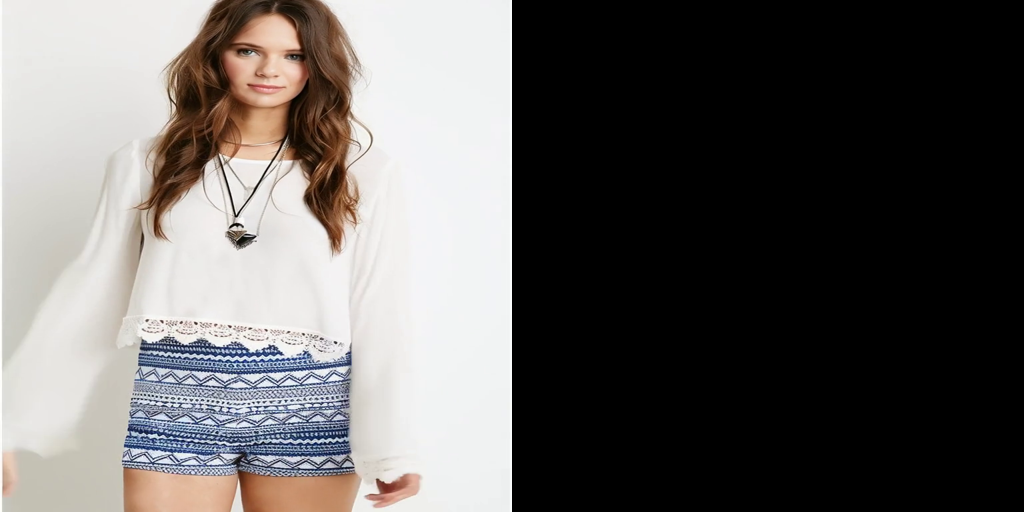

In [22]:
s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(image_size, Image.BICUBIC)

s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
s_img_t_mask.paste(s_img, (0, 0))
s_img_t_mask.paste(black_image, (s_img.width, 0))

vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
print("s_img_t_mask (vae input) image shape: ", vae_image.shape)

s_img_t_mask

### Mask (In-Painting input)

mask shape:  torch.Size([1, 1, 64, 128])


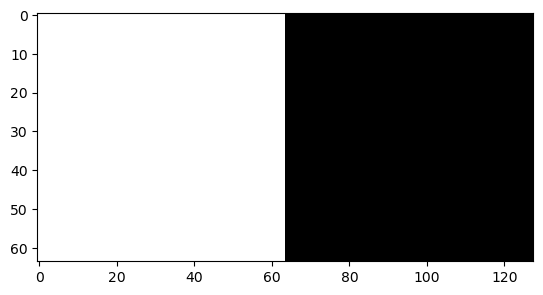

In [23]:
mask1 = torch.ones((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask0 = torch.zeros((1, 1, int(image_size[0] / 8), int(image_size[1] / 8))).to(device, dtype=torch.float16)
mask = torch.cat([mask1, mask0], dim=3)

print("mask shape: ", mask.shape)
plt.imshow(mask[0].detach().cpu().permute(1, 2, 0), cmap="gray")

### Pose Condition

put `openpose` of source image beside `openpose` of target

source image width: 512, height: 512
st_pose (condition) shape:  torch.Size([1, 3, 512, 1024])


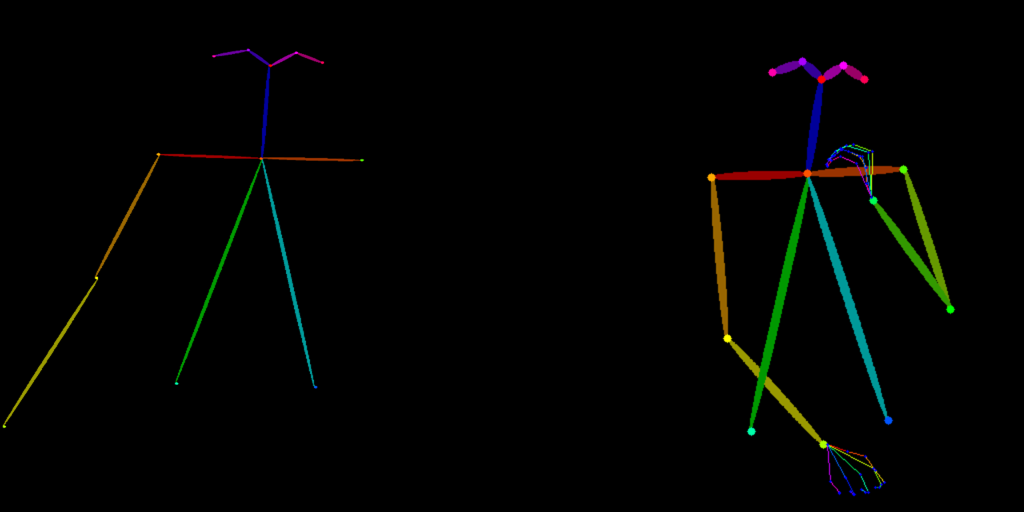

In [24]:
s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))

t_pose = Image.open(target_pose_img).convert("RGB").resize((image_size), Image.BICUBIC)

st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
st_pose.paste(s_pose, (0, 0))
st_pose.paste(t_pose, (s_pose.width, 0))

cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)
print("st_pose (condition) shape: ", cond_st_pose.shape)
st_pose

### Clip image encoder processor  -> input to Dino :XD

In [18]:
# ??clip_image_processor

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7776641..2.145897].


clip shape:  torch.Size([1, 3, 224, 224])


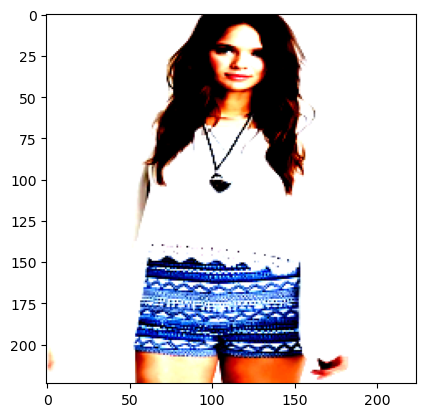

In [25]:
clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values # [1, 3, 224, 224]
print("clip shape: ", clip_s_img.shape)
plt.imshow(clip_s_img[0].permute(1, 2, 0))

## Inference

In [26]:
# just to make sure I don't have replication of models on GPU
torch.cuda.empty_cache()

In [27]:
# preprocessing step -- prepare latents, encoded embeddings, conditions

with torch.inference_mode():
    # 1. prepare conditioned pose
    cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    # 2. prepare latent 
    simg_mask_latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
    simg_mask_latents = simg_mask_latents * 0.18215 # since VAE paper do that 
    # projected encoded embeddings for both (conditional & uncondational)
    images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
    image_prompt_embeds = image_proj_model(images_embeds)
    uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))


bs_embed, seq_len, _ = image_prompt_embeds.shape
# repeat inputs to count for unconditional embeddings
image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1)
image_prompt_embeds = image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1)
uncond_image_prompt_embeds = uncond_image_prompt_embeds.view(bs_embed * num_samples, seq_len, -1)

In [28]:
# parameters you could play with
num_inference_steps = 50
guidance_scale = 2.0
num_samples = 1

output = pipe(
    simg_mask_latents= simg_mask_latents,
    mask = mask,
    cond_pose = cond_pose,
    prompt_embeds=image_prompt_embeds,
    negative_prompt_embeds=uncond_image_prompt_embeds, # ??
    height=image_size[1],
    width=image_size[0]*2, # for inpainting mask
    num_images_per_prompt=1,
    guidance_scale=guidance_scale,
    generator=generator,
    num_inference_steps=num_inference_steps,
)

  0%|          | 0/50 [00:00<?, ?it/s]

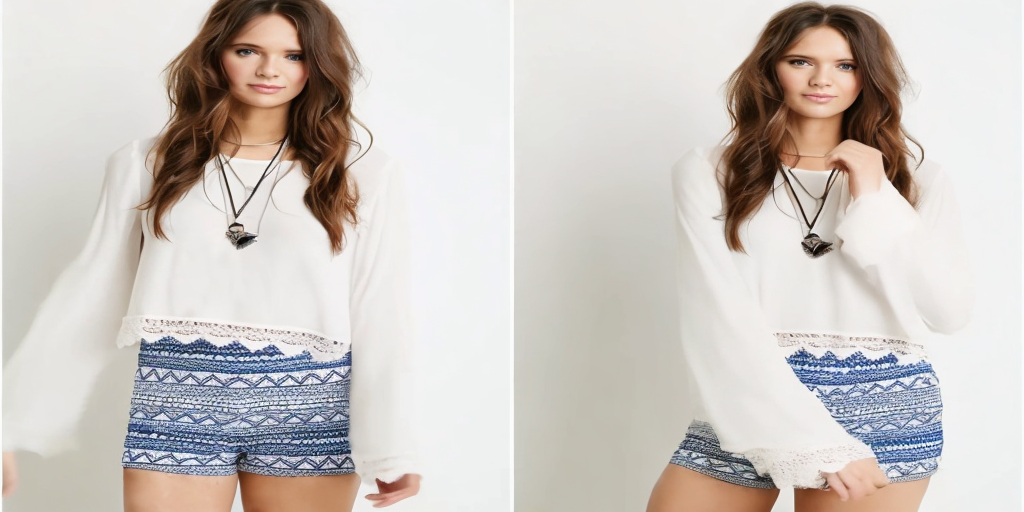

In [29]:
output.images[0]

# Inference in Function

In [35]:
def get_inpainting_inputs(s_img):
    """ concatenate source with mask - do basic processing - return latents output from VAE """
    # 1. concatenate source with mask
    black_image = Image.new("RGB", s_img.size, (0, 0, 0)).resize(s_img.size, Image.BICUBIC)
    
    s_img_t_mask = Image.new("RGB", (s_img.width * 2, s_img.height))
    s_img_t_mask.paste(s_img, (0, 0))
    s_img_t_mask.paste(black_image, (s_img.width, 0))
    # 2. do basic processing
    vae_image = torch.unsqueeze(img_transform(s_img_t_mask), 0)
    # 3. get latents from VAE
    with torch.inference_mode():
        latents = pipe.vae.encode(vae_image.to(device, dtype=torch.float16)).latent_dist.sample()
        latents = latents * 0.18215 # since VAE paper do that 
        
    return latents

def get_inpainting_cond(s_img, t_pose):
    """ concatenate source pose with target pose -- project conditions"""
    # 1. concatenate source pose with target pose
    s_pose = inference_pose(s_img_path, image_size=s_img.size).resize(s_img.size, Image.BICUBIC)
    st_pose = Image.new("RGB", (s_pose.width * 2, s_pose.height))
    st_pose.paste(s_pose, (0, 0))
    st_pose.paste(t_pose, (s_pose.width, 0))

    # 2. project conditions
    cond_st_pose = torch.unsqueeze(img_transform(st_pose), 0)
    with torch.inference_mode():
        cond_pose = pose_proj_model(cond_st_pose.to(dtype=torch.float16, device=device))
    
    return cond_pose

def get_image_embeddings(s_img, num_samples = 1):
    # do basic processing 
    clip_s_img = clip_image_processor(images=s_img, return_tensors="pt").pixel_values 
    # projected encoded embeddings for both (conditional & uncondational)
    with torch.inference_mode():
        images_embeds = image_encoder(clip_s_img.to(device, dtype=torch.float16)).last_hidden_state
        image_prompt_embeds = image_proj_model(images_embeds)
        uncond_image_prompt_embeds = image_proj_model(torch.zeros_like(images_embeds))
    
    # repeat inputs to count for unconditional embeddings
    bs_embed, seq_len, _ = image_prompt_embeds.shape
    image_prompt_embeds = image_prompt_embeds.repeat(1, num_samples, 1).view(bs_embed * num_samples, seq_len, -1)
    uncond_image_prompt_embeds = uncond_image_prompt_embeds.repeat(1, num_samples, 1).view(bs_embed * num_samples, seq_len, -1)
    
    return image_prompt_embeds, uncond_image_prompt_embeds

In [36]:
def inference_one_image(s_img_path = './imgs/img1.png', target_pose_path = './imgs/pose1.png', 
                        image_size = (512, 512),
                        num_inference_steps = 50,
                        guidance_scale = 2.0,
                       generator = generator):
    # ======================== Preprocessing ==========================================
    # 1. read image
    s_img = Image.open(s_img_path).convert("RGB").resize(image_size, Image.BICUBIC)
    t_pose = Image.open(target_pose_path).convert("RGB").resize((image_size), Image.BICUBIC)
    # 2. get inpainting input
    simg_mask_latents = get_inpainting_inputs(s_img)
    # 3. get conditional pose
    cond_pose = get_inpainting_cond(s_img, t_pose)
    # 4. get image embeddings
    image_prompt_embeds, uncond_image_prompt_embeds = get_image_embeddings(s_img)

    # ======================== Pipeline  ==========================================
    return pipe(
            simg_mask_latents= simg_mask_latents,
            mask = mask,
            cond_pose = cond_pose,
            prompt_embeds=image_prompt_embeds,
            negative_prompt_embeds=uncond_image_prompt_embeds, # ??
            height=image_size[1],
            width=image_size[0]*2, # for inpainting mask
            num_images_per_prompt=1,
            guidance_scale=guidance_scale,
            generator=generator,
            num_inference_steps=num_inference_steps,
        )

# Outputs

- it's clear that model change src image and not perserve it (IDK it's about inpainting or not)

  0%|          | 0/50 [00:00<?, ?it/s]

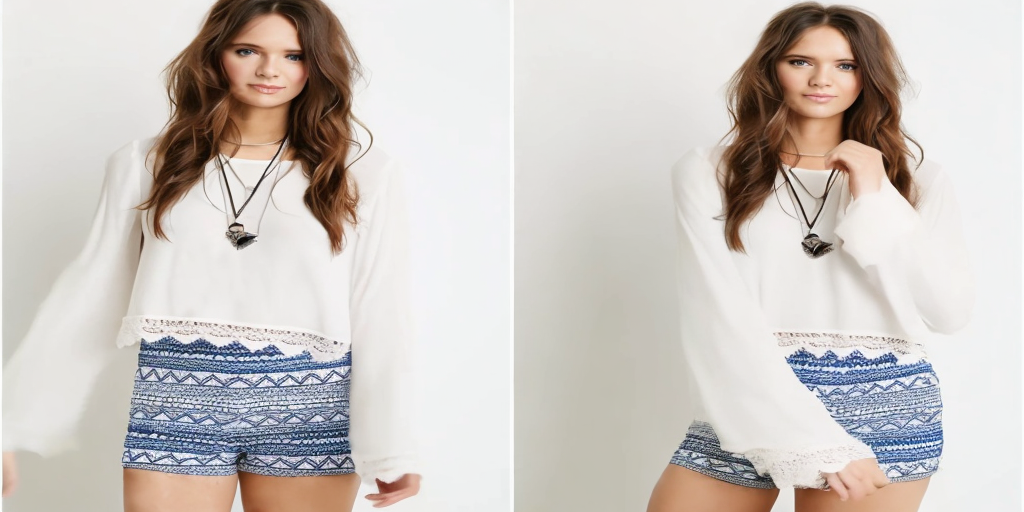

In [44]:
generator = torch.Generator(device=device).manual_seed(42)

inference_one_image(generator=generator).images[-1]

  0%|          | 0/50 [00:00<?, ?it/s]

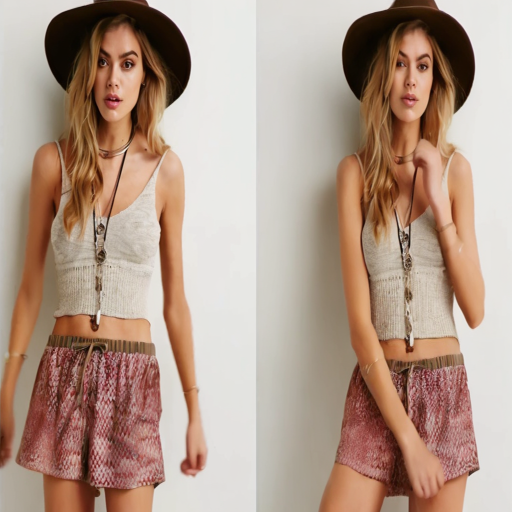

In [45]:
generator = torch.Generator(device=device).manual_seed(42)
s_img_path = './imgs/img2.png'
target_pose_path = './imgs/pose1.png'


output = inference_one_image(s_img_path, target_pose_path, generator=generator).images[-1]

output.resize((512, 512), Image.BICUBIC)

  0%|          | 0/50 [00:00<?, ?it/s]

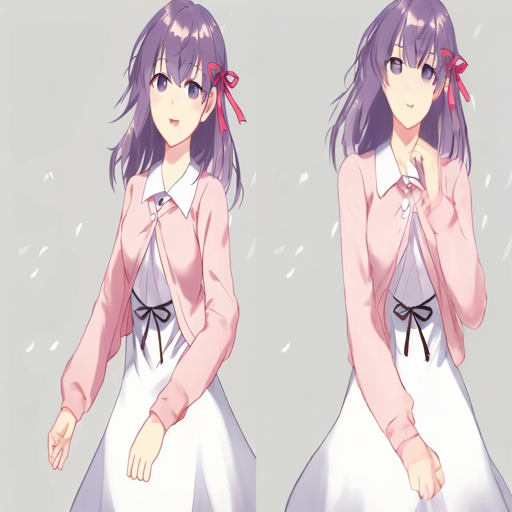

In [46]:
generator = torch.Generator(device=device).manual_seed(42)

output = inference_one_image('./imgs/img3.png', target_pose_path, generator=generator).images[-1]
output.resize((512, 512), Image.BICUBIC)

  0%|          | 0/50 [00:00<?, ?it/s]

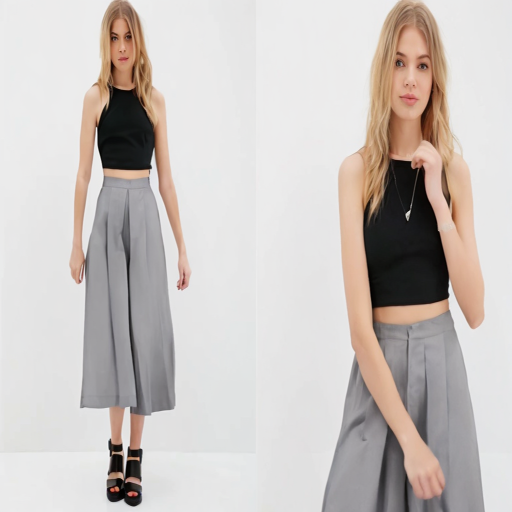

In [50]:
generator = torch.Generator(device=device).manual_seed(42)

output = inference_one_image('./imgs/img4.png', target_pose_path, generator=generator).images[-1]

output.resize((512, 512), Image.BICUBIC)

  0%|          | 0/50 [00:00<?, ?it/s]

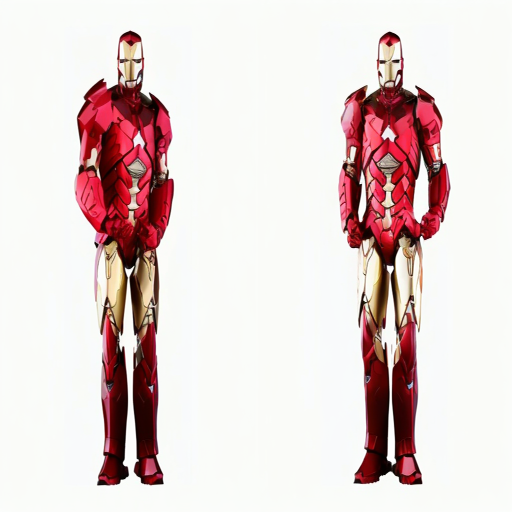

In [41]:
output = inference_one_image('./imgs/img5.png', './imgs/pose2.png').images[-1]
output.resize((512, 512), Image.BICUBIC)

  0%|          | 0/50 [00:00<?, ?it/s]

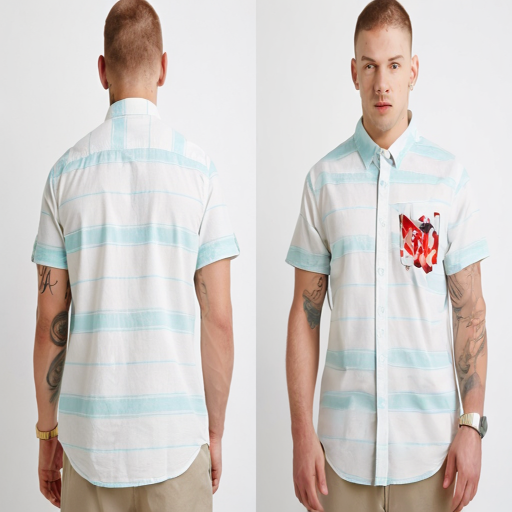

In [42]:
output = inference_one_image('./imgs/img6.png', './imgs/pose3.png').images[-1]
output.resize((512, 512), Image.BICUBIC)

  0%|          | 0/50 [00:00<?, ?it/s]

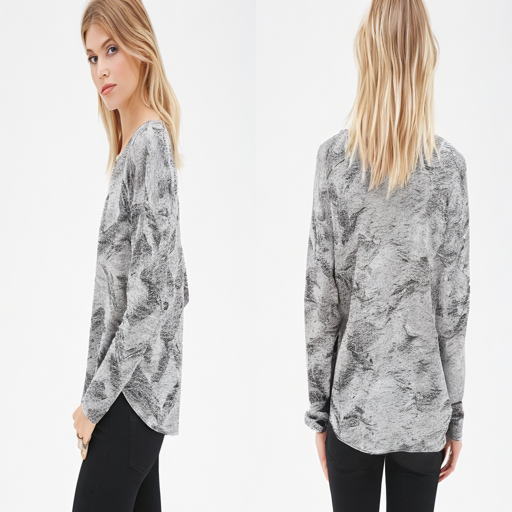

In [51]:
output = inference_one_image('./imgs/img7.png', './imgs/pose4.png').images[-1]
output.resize((512, 512), Image.BICUBIC)

In [ ]:
output = inference_one_image('./imgs/img8.png', './imgs/pose5.png').images[-1]
output.resize((512, 512), Image.BICUBIC)

In [ ]:
output = inference_one_image('./imgs/img9.png', './imgs/pose6.png').images[-1]
output.resize((512, 512), Image.BICUBIC)

## Upscaling

  0%|          | 0/50 [00:00<?, ?it/s]

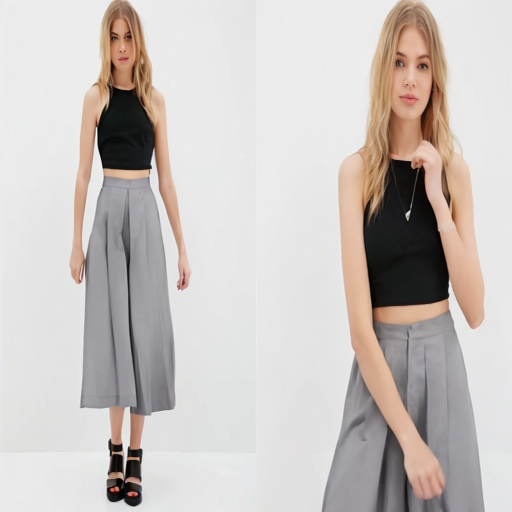

In [52]:
generator = torch.Generator(device=device).manual_seed(42)

output = inference_one_image('./imgs/img4.png', target_pose_path, generator=generator).images[-1]

output.resize((512, 512), Image.BICUBIC)

In [53]:
output.resize((512, 512), Image.BICUBIC).save('out.jpg')

In [54]:
!git clone https://github.com/xinntao/Real-ESRGAN.git

Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 759 (delta 0), reused 0 (delta 0), pack-reused 757 (from 2)
Receiving objects: 100% (759/759), 5.39 MiB | 30.99 MiB/s, done.
Resolving deltas: 100% (406/406), done.


In [56]:
!pip install basicsr facexlib gfpgan > /dev/null

In [60]:
import sys
import os
sys.path.append(os.path.abspath('Real-ESRGAN'))

# Play with Poses

body_pose_model.pth:   0%|          | 0.00/209M [00:00<?, ?B/s]

hand_pose_model.pth:   0%|          | 0.00/147M [00:00<?, ?B/s]

facenet.pth:   0%|          | 0.00/154M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/controlnet_aux/open_pose/body.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_dict = util.transfer(self.model, torch.load(

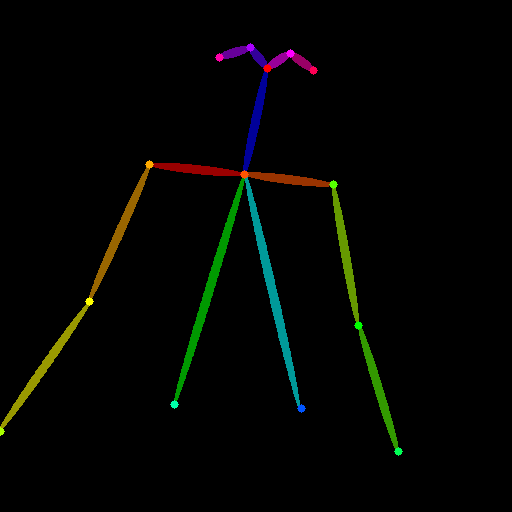

In [35]:
from controlnet_aux import OpenposeDetector
openpose = OpenposeDetector.from_pretrained("lllyasviel/ControlNet")
openpose(s_img)

source image width: 512, height: 512


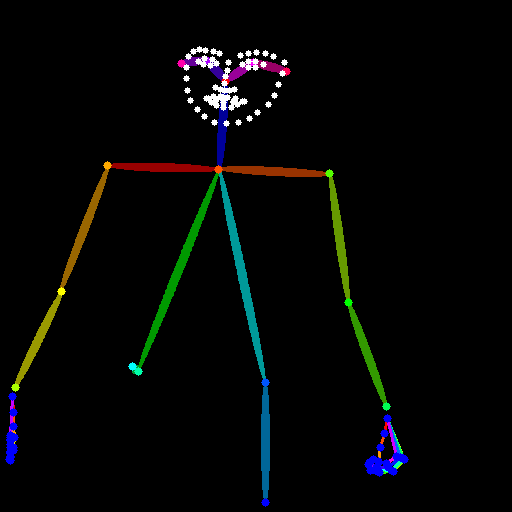

In [36]:
s_pose = inference_pose(s_img_path, image_size=(image_size[1], image_size[0])).resize(image_size, Image.BICUBIC)
print('source image width: {}, height: {}'.format(s_pose.width, s_pose.height))
s_pose